In [13]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'

In [14]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [15]:
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

In [16]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [17]:
# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')  # Initialize the best accuracy to negative infinity
    best_model_state = None  # Store the state of the best model
    best_epoch = 0  # Track the epoch with the best accuracy
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with accuracy {best_accuracy * 100:.2f}% at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Best Model was saved at epoch {best_epoch} with accuracy {best_accuracy * 100:.2f}%")
    return custom_mlp, losses, best_accuracy

In [18]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]


In [19]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 373/373 [01:42<00:00,  3.64it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 354/354 [01:52<00:00,  3.14it/s]


In [20]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 373/373 [01:42<00:00,  3.65it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 354/354 [01:52<00:00,  3.14it/s]


In [21]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")


Data successfully split into training and test sets.


Training Epochs:   2%|▏         | 11/500 [00:00<00:24, 20.05it/s]

Epoch 10/500, Loss: 0.5588
Test Accuracy at Epoch 10: 56.28%
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.64      0.23      0.34       283
non_infringement       0.55      0.88      0.67       298

        accuracy                           0.56       581
       macro avg       0.59      0.55      0.51       581
    weighted avg       0.59      0.56      0.51       581

New best model saved with accuracy 56.28% at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.64      0.23      0.34       283
non_infringement       0.55      0.88      0.67       298

        accuracy                           0.56       581
       macro avg       0.59      0.55      0.51       581
    weighted avg       0.59      0.56      0.51       581



Training Epochs:   4%|▍         | 20/500 [00:00<00:23, 20.75it/s]

Epoch 20/500, Loss: 0.5207
Test Accuracy at Epoch 20: 61.45%
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.65      0.46      0.54       283
non_infringement       0.60      0.76      0.67       298

        accuracy                           0.61       581
       macro avg       0.62      0.61      0.60       581
    weighted avg       0.62      0.61      0.61       581

New best model saved with accuracy 61.45% at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.65      0.46      0.54       283
non_infringement       0.60      0.76      0.67       298

        accuracy                           0.61       581
       macro avg       0.62      0.61      0.60       581
    weighted avg       0.62      0.61      0.61       581



Training Epochs:   6%|▋         | 32/500 [00:01<00:21, 22.04it/s]

Epoch 30/500, Loss: 0.5024
Test Accuracy at Epoch 30: 62.31%
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.67      0.45      0.54       283
non_infringement       0.60      0.79      0.68       298

        accuracy                           0.62       581
       macro avg       0.64      0.62      0.61       581
    weighted avg       0.63      0.62      0.61       581

New best model saved with accuracy 62.31% at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.67      0.45      0.54       283
non_infringement       0.60      0.79      0.68       298

        accuracy                           0.62       581
       macro avg       0.64      0.62      0.61       581
    weighted avg       0.63      0.62      0.61       581



Training Epochs:   8%|▊         | 41/500 [00:01<00:21, 21.57it/s]

Epoch 40/500, Loss: 0.4673
Test Accuracy at Epoch 40: 65.40%
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.68      0.55      0.61       283
non_infringement       0.64      0.75      0.69       298

        accuracy                           0.65       581
       macro avg       0.66      0.65      0.65       581
    weighted avg       0.66      0.65      0.65       581

New best model saved with accuracy 65.40% at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.68      0.55      0.61       283
non_infringement       0.64      0.75      0.69       298

        accuracy                           0.65       581
       macro avg       0.66      0.65      0.65       581
    weighted avg       0.66      0.65      0.65       581



Training Epochs:  11%|█         | 55/500 [00:02<00:16, 26.54it/s]

Epoch 50/500, Loss: 0.4432
Test Accuracy at Epoch 50: 67.13%
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.72      0.53      0.61       283
non_infringement       0.64      0.80      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.66       581
    weighted avg       0.68      0.67      0.66       581

New best model saved with accuracy 67.13% at epoch 50
Best Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.72      0.53      0.61       283
non_infringement       0.64      0.80      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.66       581
    weighted avg       0.68      0.67      0.66       581



Training Epochs:  13%|█▎        | 65/500 [00:02<00:15, 28.30it/s]

Epoch 60/500, Loss: 0.4189
Test Accuracy at Epoch 60: 66.95%
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.70      0.57      0.62       283
non_infringement       0.65      0.77      0.70       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.66       581
    weighted avg       0.67      0.67      0.67       581



Training Epochs:  15%|█▌        | 76/500 [00:03<00:14, 30.10it/s]

Epoch 70/500, Loss: 0.3943
Test Accuracy at Epoch 70: 64.03%
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.64      0.60      0.62       283
non_infringement       0.64      0.68      0.66       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.64       581
    weighted avg       0.64      0.64      0.64       581



Training Epochs:  17%|█▋        | 84/500 [00:03<00:14, 29.35it/s]

Epoch 80/500, Loss: 0.3859
Test Accuracy at Epoch 80: 63.34%
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.72      0.40      0.51       283
non_infringement       0.60      0.86      0.71       298

        accuracy                           0.63       581
       macro avg       0.66      0.63      0.61       581
    weighted avg       0.66      0.63      0.61       581



Training Epochs:  18%|█▊        | 92/500 [00:03<00:12, 31.95it/s]

Epoch 90/500, Loss: 0.3832
Test Accuracy at Epoch 90: 58.18%
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.56      0.64      0.60       283
non_infringement       0.61      0.53      0.57       298

        accuracy                           0.58       581
       macro avg       0.58      0.58      0.58       581
    weighted avg       0.58      0.58      0.58       581



Training Epochs:  21%|██        | 104/500 [00:04<00:12, 31.88it/s]

Epoch 100/500, Loss: 0.3622
Test Accuracy at Epoch 100: 65.40%
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.69      0.53      0.60       283
non_infringement       0.63      0.77      0.69       298

        accuracy                           0.65       581
       macro avg       0.66      0.65      0.65       581
    weighted avg       0.66      0.65      0.65       581



Training Epochs:  23%|██▎       | 116/500 [00:04<00:11, 32.22it/s]

Epoch 110/500, Loss: 0.3434
Test Accuracy at Epoch 110: 65.58%
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.69      0.53      0.60       283
non_infringement       0.64      0.77      0.70       298

        accuracy                           0.66       581
       macro avg       0.66      0.65      0.65       581
    weighted avg       0.66      0.66      0.65       581



Training Epochs:  25%|██▍       | 124/500 [00:04<00:12, 30.80it/s]

Epoch 120/500, Loss: 0.3329
Test Accuracy at Epoch 120: 63.51%
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.63      0.61      0.62       283
non_infringement       0.64      0.66      0.65       298

        accuracy                           0.64       581
       macro avg       0.63      0.63      0.63       581
    weighted avg       0.63      0.64      0.63       581



Training Epochs:  27%|██▋       | 133/500 [00:05<00:11, 30.97it/s]

Epoch 130/500, Loss: 0.3917
Test Accuracy at Epoch 130: 63.51%
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.73      0.40      0.51       283
non_infringement       0.60      0.86      0.71       298

        accuracy                           0.64       581
       macro avg       0.67      0.63      0.61       581
    weighted avg       0.66      0.64      0.61       581



Training Epochs:  28%|██▊       | 142/500 [00:05<00:10, 33.63it/s]

Epoch 140/500, Loss: 0.3228
Test Accuracy at Epoch 140: 63.51%
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.64      0.59      0.61       283
non_infringement       0.63      0.68      0.66       298

        accuracy                           0.64       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.64      0.63       581



Training Epochs:  31%|███       | 154/500 [00:05<00:10, 33.56it/s]

Epoch 150/500, Loss: 0.3077
Test Accuracy at Epoch 150: 65.58%
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.68      0.56      0.61       283
non_infringement       0.64      0.75      0.69       298

        accuracy                           0.66       581
       macro avg       0.66      0.65      0.65       581
    weighted avg       0.66      0.66      0.65       581



Training Epochs:  33%|███▎      | 166/500 [00:06<00:10, 30.77it/s]

Epoch 160/500, Loss: 0.2972
Test Accuracy at Epoch 160: 65.40%
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.68      0.55      0.61       283
non_infringement       0.64      0.75      0.69       298

        accuracy                           0.65       581
       macro avg       0.66      0.65      0.65       581
    weighted avg       0.66      0.65      0.65       581



Training Epochs:  35%|███▍      | 174/500 [00:06<00:11, 29.60it/s]

Epoch 170/500, Loss: 0.3201
Test Accuracy at Epoch 170: 66.09%
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.68      0.57      0.62       283
non_infringement       0.65      0.75      0.69       298

        accuracy                           0.66       581
       macro avg       0.66      0.66      0.66       581
    weighted avg       0.66      0.66      0.66       581



Training Epochs:  37%|███▋      | 186/500 [00:06<00:10, 29.01it/s]

Epoch 180/500, Loss: 0.2815
Test Accuracy at Epoch 180: 67.30%
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.70      0.58      0.63       283
non_infringement       0.66      0.77      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.67       581
    weighted avg       0.68      0.67      0.67       581

New best model saved with accuracy 67.30% at epoch 180
Best Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.70      0.58      0.63       283
non_infringement       0.66      0.77      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.67       581
    weighted avg       0.68      0.67      0.67       581



Training Epochs:  39%|███▉      | 195/500 [00:07<00:09, 32.64it/s]

Epoch 190/500, Loss: 0.2780
Test Accuracy at Epoch 190: 67.30%
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.70      0.58      0.63       283
non_infringement       0.66      0.77      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.67       581
    weighted avg       0.68      0.67      0.67       581



Training Epochs:  41%|████      | 205/500 [00:07<00:08, 33.95it/s]

Epoch 200/500, Loss: 0.2691
Test Accuracy at Epoch 200: 66.78%
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.68      0.59      0.63       283
non_infringement       0.66      0.74      0.70       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.66       581
    weighted avg       0.67      0.67      0.67       581



Training Epochs:  43%|████▎     | 213/500 [00:07<00:09, 31.19it/s]

Epoch 210/500, Loss: 0.4276
Test Accuracy at Epoch 210: 64.37%
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.63      0.66      0.64       283
non_infringement       0.66      0.63      0.64       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.64       581
    weighted avg       0.64      0.64      0.64       581



Training Epochs:  45%|████▍     | 224/500 [00:08<00:09, 29.17it/s]

Epoch 220/500, Loss: 0.2723
Test Accuracy at Epoch 220: 66.95%
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.68      0.60      0.64       283
non_infringement       0.66      0.73      0.70       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581



Training Epochs:  47%|████▋     | 233/500 [00:08<00:10, 25.57it/s]

Epoch 230/500, Loss: 0.2615
Test Accuracy at Epoch 230: 67.30%
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.69      0.59      0.64       283
non_infringement       0.66      0.75      0.70       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.67       581
    weighted avg       0.68      0.67      0.67       581



Training Epochs:  48%|████▊     | 242/500 [00:08<00:10, 24.46it/s]

Epoch 240/500, Loss: 0.4474
Test Accuracy at Epoch 240: 63.34%
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.68      0.46      0.55       283
non_infringement       0.61      0.80      0.69       298

        accuracy                           0.63       581
       macro avg       0.65      0.63      0.62       581
    weighted avg       0.65      0.63      0.62       581



Training Epochs:  50%|█████     | 251/500 [00:09<00:10, 23.89it/s]

Epoch 250/500, Loss: 0.2788
Test Accuracy at Epoch 250: 66.44%
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.68      0.59      0.63       283
non_infringement       0.65      0.73      0.69       298

        accuracy                           0.66       581
       macro avg       0.67      0.66      0.66       581
    weighted avg       0.67      0.66      0.66       581



Training Epochs:  53%|█████▎    | 263/500 [00:09<00:10, 21.95it/s]

Epoch 260/500, Loss: 0.2611
Test Accuracy at Epoch 260: 64.20%
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.64      0.60      0.62       283
non_infringement       0.64      0.68      0.66       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.64       581
    weighted avg       0.64      0.64      0.64       581



Training Epochs:  55%|█████▍    | 274/500 [00:10<00:09, 24.81it/s]

Epoch 270/500, Loss: 0.2403
Test Accuracy at Epoch 270: 66.44%
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.67      0.60      0.64       283
non_infringement       0.66      0.72      0.69       298

        accuracy                           0.66       581
       macro avg       0.67      0.66      0.66       581
    weighted avg       0.67      0.66      0.66       581



Training Epochs:  57%|█████▋    | 283/500 [00:10<00:09, 22.90it/s]

Epoch 280/500, Loss: 0.2359
Test Accuracy at Epoch 280: 67.47%
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.69      0.61      0.65       283
non_infringement       0.67      0.73      0.70       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.67       581
    weighted avg       0.68      0.67      0.67       581

New best model saved with accuracy 67.47% at epoch 280
Best Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.69      0.61      0.65       283
non_infringement       0.67      0.73      0.70       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.67       581
    weighted avg       0.68      0.67      0.67       581



Training Epochs:  58%|█████▊    | 292/500 [00:10<00:09, 22.08it/s]

Epoch 290/500, Loss: 0.2431
Test Accuracy at Epoch 290: 63.51%
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.69      0.46      0.55       283
non_infringement       0.61      0.80      0.69       298

        accuracy                           0.64       581
       macro avg       0.65      0.63      0.62       581
    weighted avg       0.65      0.64      0.62       581



Training Epochs:  61%|██████    | 304/500 [00:11<00:08, 23.61it/s]

Epoch 300/500, Loss: 0.3475
Test Accuracy at Epoch 300: 64.72%
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.67      0.53      0.60       283
non_infringement       0.63      0.76      0.69       298

        accuracy                           0.65       581
       macro avg       0.65      0.64      0.64       581
    weighted avg       0.65      0.65      0.64       581



Training Epochs:  63%|██████▎   | 313/500 [00:11<00:08, 22.45it/s]

Epoch 310/500, Loss: 0.2534
Test Accuracy at Epoch 310: 64.89%
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.65      0.62      0.63       283
non_infringement       0.65      0.68      0.66       298

        accuracy                           0.65       581
       macro avg       0.65      0.65      0.65       581
    weighted avg       0.65      0.65      0.65       581



Training Epochs:  65%|██████▍   | 323/500 [00:12<00:07, 24.67it/s]

Epoch 320/500, Loss: 0.2386
Test Accuracy at Epoch 320: 65.92%
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.69      0.54      0.61       283
non_infringement       0.64      0.77      0.70       298

        accuracy                           0.66       581
       macro avg       0.67      0.66      0.65       581
    weighted avg       0.66      0.66      0.65       581



Training Epochs:  67%|██████▋   | 333/500 [00:12<00:06, 25.19it/s]

Epoch 330/500, Loss: 0.2270
Test Accuracy at Epoch 330: 66.78%
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.69      0.58      0.63       283
non_infringement       0.65      0.75      0.70       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.66       581
    weighted avg       0.67      0.67      0.67       581



Training Epochs:  69%|██████▉   | 344/500 [00:12<00:05, 27.48it/s]

Epoch 340/500, Loss: 0.2214
Test Accuracy at Epoch 340: 67.13%
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.69      0.60      0.64       283
non_infringement       0.66      0.74      0.70       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581



Training Epochs:  70%|███████   | 352/500 [00:13<00:04, 31.59it/s]

Epoch 350/500, Loss: 0.2175
Test Accuracy at Epoch 350: 67.30%
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.69      0.60      0.64       283
non_infringement       0.66      0.74      0.70       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581



Training Epochs:  73%|███████▎  | 366/500 [00:13<00:03, 35.06it/s]

Epoch 360/500, Loss: 0.2141
Test Accuracy at Epoch 360: 67.13%
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.69      0.59      0.64       283
non_infringement       0.66      0.74      0.70       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581



Training Epochs:  75%|███████▍  | 374/500 [00:13<00:03, 34.38it/s]

Epoch 370/500, Loss: 0.2114
Test Accuracy at Epoch 370: 67.47%
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.69      0.60      0.64       283
non_infringement       0.66      0.75      0.70       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.67       581
    weighted avg       0.68      0.67      0.67       581



Training Epochs:  77%|███████▋  | 383/500 [00:14<00:03, 38.00it/s]

Epoch 380/500, Loss: 0.2094
Test Accuracy at Epoch 380: 65.23%
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.68      0.54      0.60       283
non_infringement       0.64      0.76      0.69       298

        accuracy                           0.65       581
       macro avg       0.66      0.65      0.65       581
    weighted avg       0.66      0.65      0.65       581



Training Epochs:  79%|███████▉  | 396/500 [00:14<00:02, 38.33it/s]

Epoch 390/500, Loss: 0.6492
Test Accuracy at Epoch 390: 62.99%
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.64      0.56      0.60       283
non_infringement       0.62      0.70      0.66       298

        accuracy                           0.63       581
       macro avg       0.63      0.63      0.63       581
    weighted avg       0.63      0.63      0.63       581



Training Epochs:  81%|████████  | 404/500 [00:14<00:02, 34.44it/s]

Epoch 400/500, Loss: 0.2763
Test Accuracy at Epoch 400: 61.10%
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.63      0.49      0.55       283
non_infringement       0.60      0.72      0.66       298

        accuracy                           0.61       581
       macro avg       0.61      0.61      0.60       581
    weighted avg       0.61      0.61      0.61       581



Training Epochs:  83%|████████▎ | 413/500 [00:14<00:02, 36.93it/s]

Epoch 410/500, Loss: 0.2511
Test Accuracy at Epoch 410: 62.48%
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.63      0.57      0.60       283
non_infringement       0.62      0.67      0.65       298

        accuracy                           0.62       581
       macro avg       0.62      0.62      0.62       581
    weighted avg       0.62      0.62      0.62       581



Training Epochs:  85%|████████▌ | 426/500 [00:15<00:01, 37.99it/s]

Epoch 420/500, Loss: 0.2356
Test Accuracy at Epoch 420: 64.89%
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.67      0.56      0.61       283
non_infringement       0.64      0.73      0.68       298

        accuracy                           0.65       581
       macro avg       0.65      0.65      0.65       581
    weighted avg       0.65      0.65      0.65       581



Training Epochs:  87%|████████▋ | 435/500 [00:15<00:01, 36.49it/s]

Epoch 430/500, Loss: 0.2246
Test Accuracy at Epoch 430: 65.23%
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.67      0.55      0.61       283
non_infringement       0.64      0.74      0.69       298

        accuracy                           0.65       581
       macro avg       0.66      0.65      0.65       581
    weighted avg       0.66      0.65      0.65       581



Training Epochs:  89%|████████▉ | 445/500 [00:15<00:01, 35.99it/s]

Epoch 440/500, Loss: 0.2177
Test Accuracy at Epoch 440: 65.92%
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.68      0.57      0.62       283
non_infringement       0.64      0.75      0.69       298

        accuracy                           0.66       581
       macro avg       0.66      0.66      0.66       581
    weighted avg       0.66      0.66      0.66       581



Training Epochs:  91%|█████████ | 455/500 [00:15<00:01, 39.34it/s]

Epoch 450/500, Loss: 0.2138
Test Accuracy at Epoch 450: 65.92%
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.68      0.57      0.62       283
non_infringement       0.64      0.75      0.69       298

        accuracy                           0.66       581
       macro avg       0.66      0.66      0.66       581
    weighted avg       0.66      0.66      0.66       581



Training Epochs:  93%|█████████▎| 464/500 [00:16<00:00, 36.19it/s]

Epoch 460/500, Loss: 0.2108
Test Accuracy at Epoch 460: 65.40%
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.68      0.55      0.61       283
non_infringement       0.64      0.75      0.69       298

        accuracy                           0.65       581
       macro avg       0.66      0.65      0.65       581
    weighted avg       0.66      0.65      0.65       581



Training Epochs:  95%|█████████▌| 476/500 [00:16<00:00, 35.04it/s]

Epoch 470/500, Loss: 0.2085
Test Accuracy at Epoch 470: 65.23%
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.68      0.55      0.61       283
non_infringement       0.64      0.75      0.69       298

        accuracy                           0.65       581
       macro avg       0.66      0.65      0.65       581
    weighted avg       0.66      0.65      0.65       581



Training Epochs:  97%|█████████▋| 485/500 [00:16<00:00, 38.46it/s]

Epoch 480/500, Loss: 0.2068
Test Accuracy at Epoch 480: 65.40%
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.68      0.56      0.61       283
non_infringement       0.64      0.74      0.69       298

        accuracy                           0.65       581
       macro avg       0.66      0.65      0.65       581
    weighted avg       0.66      0.65      0.65       581



Training Epochs: 100%|█████████▉| 498/500 [00:17<00:00, 38.76it/s]

Epoch 490/500, Loss: 0.2054
Test Accuracy at Epoch 490: 65.40%
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.68      0.56      0.61       283
non_infringement       0.64      0.74      0.69       298

        accuracy                           0.65       581
       macro avg       0.66      0.65      0.65       581
    weighted avg       0.66      0.65      0.65       581



Training Epochs: 100%|██████████| 500/500 [00:17<00:00, 29.00it/s]
/tmp/ipykernel_2539701/3960048660.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_sta

Epoch 500/500, Loss: 0.2042
Test Accuracy at Epoch 500: 65.40%
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.68      0.56      0.61       283
non_infringement       0.64      0.74      0.69       298

        accuracy                           0.65       581
       macro avg       0.66      0.65      0.65       581
    weighted avg       0.66      0.65      0.65       581



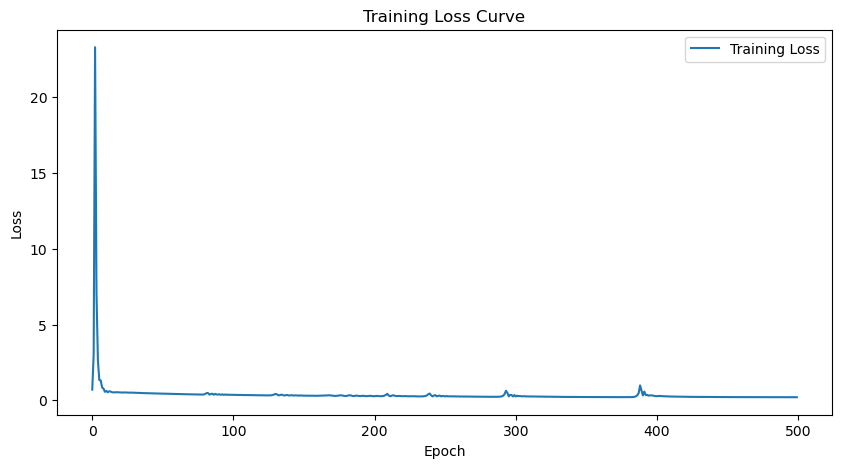

Best Model was saved at epoch 280 with accuracy 67.47%


In [22]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [23]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'.


In [24]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 67.47%


/tmp/ipykernel_2539701/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


                  precision    recall  f1-score   support

    infringement       0.69      0.61      0.65       283
non_infringement       0.67      0.73      0.70       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.67       581
    weighted avg       0.68      0.67      0.67       581

